In [1]:
# pip install git+https://github.com/IBM/tsfm.git
# pip install transformers
# pip install bottleneck --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from transformers import EarlyStoppingCallback, PatchTSTConfig, PatchTSTForPrediction, Trainer, TrainingArguments
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

In [3]:
dataset_path = r"Data\participant_training_jobs_full_data.csv"
timestamp_column = "timestamp"
id_columns = ['job_id', 'host']
forecast_columns = ['cpuuser','gpu_usage','memused','memused_minus_diskcache'] # ['block','cpuuser','gpu_usage','memused','memused_minus_diskcache','nfs']
context_length = 30
forecast_horizon = 1
patch_length = 6
num_workers = 8
batch_size = 8


data = pd.read_csv(dataset_path, parse_dates=[timestamp_column])
data.drop(['ts_delta'], axis=1, inplace=True)

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=10,
    end_index=60
)
val_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=60-context_length,
    end_index=None
)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    scaling=True
)

time_series_preprocessor = time_series_preprocessor.train(train_data)

train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon
)
val_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(val_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon
)

config = PatchTSTConfig(
    num_input_channels=len(forecast_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.2,
    d_model=90, # 128
    num_attention_heads=15, # 16
    num_hidden_layers=3,
    ffn_dim=180, # 256
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=True,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="layernorm"
)
model = PatchTSTForPrediction(config)

training_args = TrainingArguments(
    output_dir=r"Data\results",
    overwrite_output_dir=True,
    num_train_epochs=10,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir=r"Data\logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False, 
    label_names=["future_values"],
    # learning_rate=0.1,
    # adam_epsilon=1e-5,
    # adam_beta2=0.97,
    lr_scheduler_type='cosine_with_restarts'

)

print(training_args.device)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,
    early_stopping_threshold=0.0001
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping_callback],
    # compute_metrics=compute_metrics,
)

cuda:0


In [4]:
trainer.train()

  0%|          | 0/34250 [00:00<?, ?it/s]

{'loss': 0.6861, 'grad_norm': 4.407775402069092, 'learning_rate': 4.877641290737884e-05, 'epoch': 1.0}


  0%|          | 0/1581 [00:00<?, ?it/s]

{'eval_loss': 148.05335998535156, 'eval_runtime': 513.8803, 'eval_samples_per_second': 24.601, 'eval_steps_per_second': 3.077, 'epoch': 1.0}
{'loss': 0.6434, 'grad_norm': 11.136077880859375, 'learning_rate': 4.522542485937369e-05, 'epoch': 2.0}


  0%|          | 0/1581 [00:00<?, ?it/s]

{'eval_loss': 138.5540771484375, 'eval_runtime': 560.9352, 'eval_samples_per_second': 22.537, 'eval_steps_per_second': 2.819, 'epoch': 2.0}
{'loss': 0.6331, 'grad_norm': 3.089043378829956, 'learning_rate': 3.969463130731183e-05, 'epoch': 3.0}


  0%|          | 0/1581 [00:00<?, ?it/s]

{'eval_loss': 144.35256958007812, 'eval_runtime': 604.2103, 'eval_samples_per_second': 20.923, 'eval_steps_per_second': 2.617, 'epoch': 3.0}
{'loss': 0.6267, 'grad_norm': 3.506390333175659, 'learning_rate': 3.272542485937369e-05, 'epoch': 4.0}


  0%|          | 0/1581 [00:00<?, ?it/s]

{'eval_loss': 141.88096618652344, 'eval_runtime': 686.5743, 'eval_samples_per_second': 18.413, 'eval_steps_per_second': 2.303, 'epoch': 4.0}
{'loss': 0.6212, 'grad_norm': 3.911285877227783, 'learning_rate': 2.5e-05, 'epoch': 5.0}


  0%|          | 0/1581 [00:00<?, ?it/s]

{'eval_loss': 120.10350799560547, 'eval_runtime': 677.5168, 'eval_samples_per_second': 18.659, 'eval_steps_per_second': 2.334, 'epoch': 5.0}
{'loss': 0.6166, 'grad_norm': 4.51113748550415, 'learning_rate': 1.7274575140626318e-05, 'epoch': 6.0}


  0%|          | 0/1581 [00:00<?, ?it/s]

{'eval_loss': 136.9290313720703, 'eval_runtime': 698.5906, 'eval_samples_per_second': 18.096, 'eval_steps_per_second': 2.263, 'epoch': 6.0}
{'loss': 0.6137, 'grad_norm': 3.0604913234710693, 'learning_rate': 1.0305368692688174e-05, 'epoch': 7.0}


  0%|          | 0/1581 [00:00<?, ?it/s]

{'eval_loss': 132.42930603027344, 'eval_runtime': 714.2282, 'eval_samples_per_second': 17.7, 'eval_steps_per_second': 2.214, 'epoch': 7.0}
{'loss': 0.6115, 'grad_norm': 4.828803062438965, 'learning_rate': 4.7745751406263165e-06, 'epoch': 8.0}


  0%|          | 0/1581 [00:00<?, ?it/s]

{'eval_loss': 128.42254638671875, 'eval_runtime': 323.6527, 'eval_samples_per_second': 39.06, 'eval_steps_per_second': 4.885, 'epoch': 8.0}
{'loss': 0.6096, 'grad_norm': 4.160970687866211, 'learning_rate': 1.2235870926211619e-06, 'epoch': 9.0}


  0%|          | 0/1581 [00:00<?, ?it/s]

{'eval_loss': 131.21600341796875, 'eval_runtime': 292.7859, 'eval_samples_per_second': 43.178, 'eval_steps_per_second': 5.4, 'epoch': 9.0}
{'loss': 0.6083, 'grad_norm': 1.756981372833252, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/1581 [00:00<?, ?it/s]

{'eval_loss': 129.38233947753906, 'eval_runtime': 288.38, 'eval_samples_per_second': 43.838, 'eval_steps_per_second': 5.482, 'epoch': 10.0}
{'train_runtime': 6744.0521, 'train_samples_per_second': 40.628, 'train_steps_per_second': 5.079, 'train_loss': 0.6270233020643248, 'epoch': 10.0}


TrainOutput(global_step=34250, training_loss=0.6270233020643248, metrics={'train_runtime': 6744.0521, 'train_samples_per_second': 40.628, 'train_steps_per_second': 5.079, 'total_flos': 39345720480000.0, 'train_loss': 0.6270233020643248, 'epoch': 10.0})

In [5]:
predictions = trainer.predict(test_dataset=val_dataset)

  0%|          | 0/1581 [00:00<?, ?it/s]

In [6]:
def trainer_prediction_output_to_df(output, idx:int, features_list:list, count:int=12642, features:int=6):
    result_prediction = pd.DataFrame({key:list(output[0][idx].reshape((count,features))[:, features_list.index(key)]) for key in features_list})
    result_prediction['type'] = 'prediction'
    result_truth= pd.DataFrame({key:list(output[1].reshape((count,features))[:, features_list.index(key)]) for key in features_list})
    result_truth['type'] = 'truth'


    return pd.concat([result_prediction, result_truth])
    # return pd.DataFrame({
    #     'block':list(output[0][idx].reshape((count,features))[:, 0])+list(output[1].reshape((count,features))[:, 0]),
    #     'cpuuser':list(output[0][idx].reshape((count,features))[:, 1])+list(output[1].reshape((count,features))[:, 1]),
    #     'gpu_usage':list(output[0][idx].reshape((count,features))[:, 2])+list(output[1].reshape((count,features))[:, 2]),
    #     'memused':list(output[0][idx].reshape((count,features))[:, 3])+list(output[1].reshape((count,features))[:, 3]),
    #     'memused_minus_diskcache':list(output[0][1].reshape((count,features))[:, 4])+list(output[1].reshape((count,features))[:, 4]),
    #     'nfs':list(output[0][idx].reshape((count,features))[:, 5])+list(output[1].reshape((count,features))[:, 5]),
    #     'type':['prediction']*count + ['truth']*count
    #     })

In [7]:
def trainer_prediction_output_to_df_v2(output):
    return pd.DataFrame({
        'block_prediction':output[0][1].reshape((12642,6))[:, 0],
        'block_truth':output[1].reshape((12642,6))[:, 0],
        'cpuuser_prediction':output[0][1].reshape((12642,6))[:, 1],
        'cpuuser_truth':output[1].reshape((12642,6))[:, 1],
        'gpu_usage_prediction':output[0][1].reshape((12642,6))[:, 2],
        'gpu_usage_truth':output[1].reshape((12642,6))[:, 2],
        'memused_prediction':output[0][1].reshape((12642,6))[:, 3],
        'memused_truth':output[1].reshape((12642,6))[:, 3],
        'memused_minus_diskcache_prediction':output[0][1].reshape((12642,6))[:, 4],
        'memused_minus_diskcache_truth':output[1].reshape((12642,6))[:, 4],
        'nfs_prediction':output[0][1].reshape((12642,6))[:, 5],
        'nfs_truth':output[1].reshape((12642,6))[:, 5]
    })

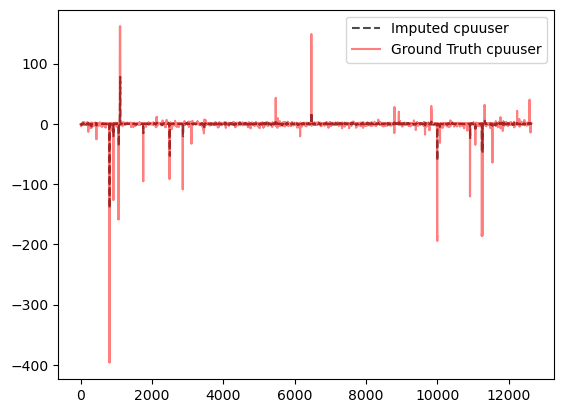

RMSE: 14.696990887174671


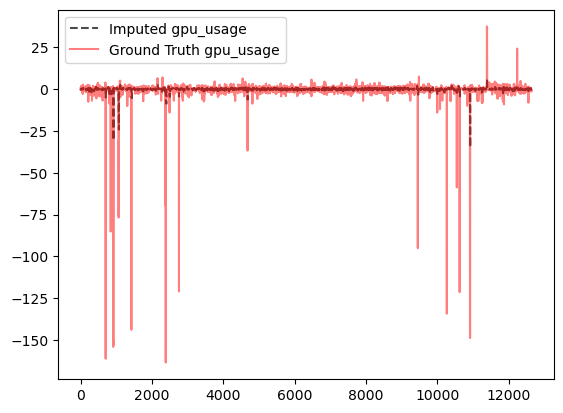

RMSE: 6.111630542912947


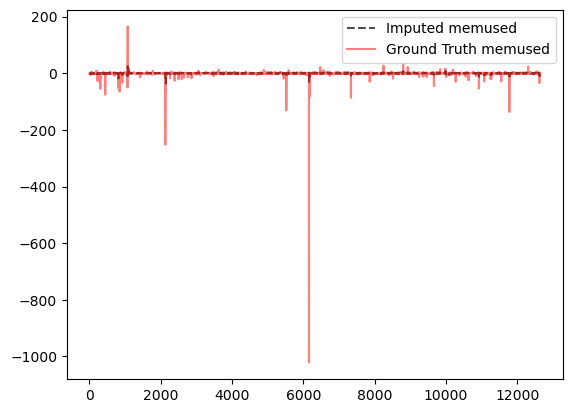

RMSE: 14.434177297066988


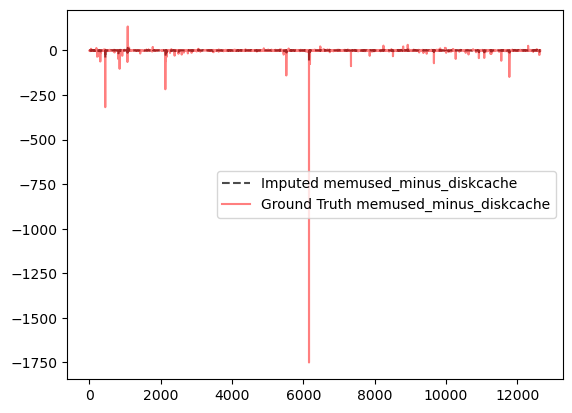

RMSE: 23.39434829668402


In [8]:
val_out = trainer_prediction_output_to_df(output=predictions, idx=1, features_list=forecast_columns, count=12642, features=4)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")

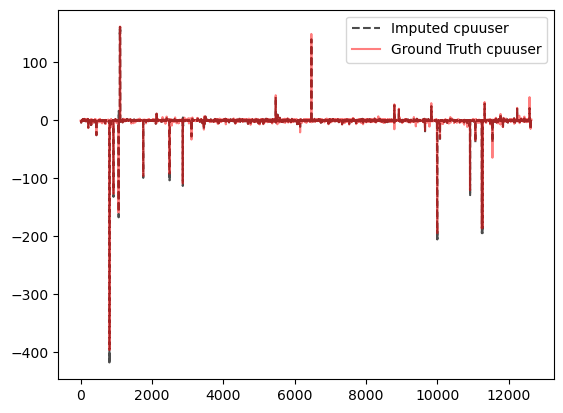

RMSE: 5.43897674501711


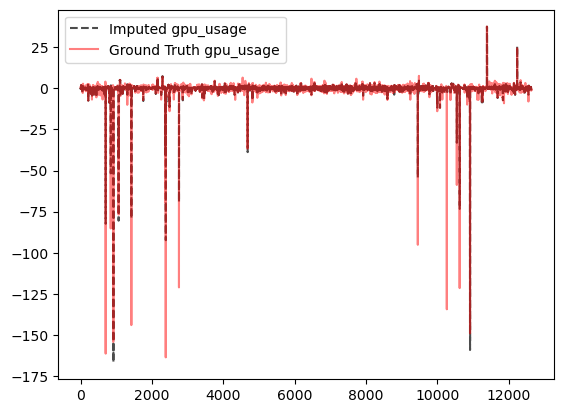

RMSE: 4.748328466942916


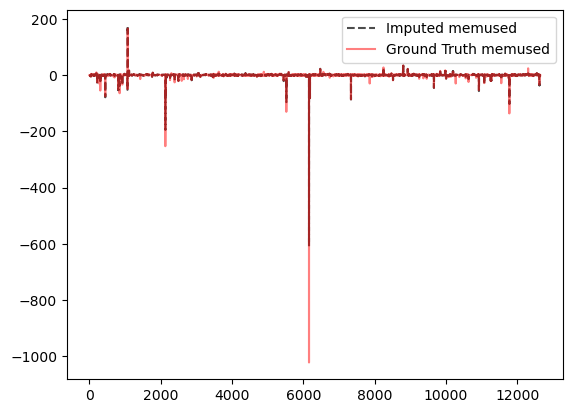

RMSE: 10.809957392747107


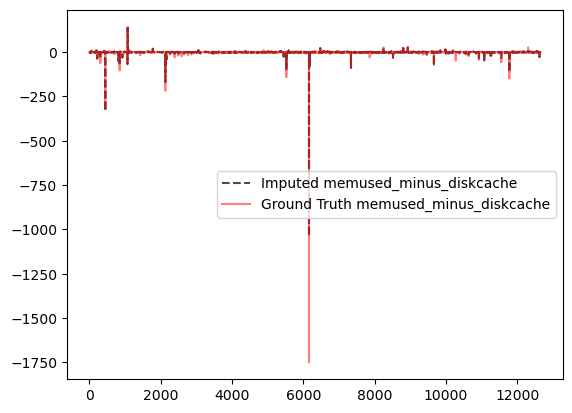

RMSE: 17.6473722841435


In [12]:
val_out = trainer_prediction_output_to_df(output=predictions, idx=0, features_list=forecast_columns, count=12642, features=4)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")

In [10]:
# alt

id_columns = []

data = pd.read_csv(dataset_path, parse_dates=[timestamp_column])
data.drop(['ts_delta','job_id', 'host'], axis=1, inplace=True)

num_train = int(len(data) * 0.7)
num_test = int(len(data) * 0.2)
num_valid = len(data) - num_train - num_test
border1s = [
    0,
    num_train - context_length,
    len(data) - num_test - context_length,
]
border2s = [num_train, num_train + num_valid, len(data)]

train_start_index = border1s[0]
train_end_index = border2s[0]

valid_start_index = border1s[1]
valid_end_index = border2s[1]


train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
val_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    scaling=True,
)

time_series_preprocessor = time_series_preprocessor.train(train_data)

train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
val_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(val_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)

config = PatchTSTConfig(
    num_input_channels=len(forecast_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.2,
    d_model=90, # 128
    num_attention_heads=15, # 16
    num_hidden_layers=3,
    ffn_dim=180, # 256
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=False,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="batchnorm",
)
model = PatchTSTForPrediction(config)

training_args = TrainingArguments(
    output_dir=r"Data\results_alt",
    overwrite_output_dir=True,
    num_train_epochs=2,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir=r"Data\logs_alt",
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0001,  # Minimum improvement required to consider as improvement
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping_callback],
    # compute_metrics=compute_metrics,
)

c:\Users\danie\anaconda3\envs\new_env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
trainer.train()

  0%|          | 0/16590 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
predictions = trainer.predict(test_dataset=val_dataset)

In [ ]:
val_out = trainer_prediction_output_to_df(predictions, 0)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")

In [ ]:
val_out = trainer_prediction_output_to_df(predictions, 1)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")